In [25]:
# Import python libraries and define directories
import os
import glob
import random
import torch
import wandb

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from pathlib import Path

import pandas as pd
import seaborn as sns

from opensoundscape import AudioFileDataset, BoxedAnnotations, CNN, SpectrogramPreprocessor
from opensoundscape.ml.cnn import load_model
from opensoundscape.preprocess.utils import show_tensor_grid
from opensoundscape.utils import set_seed

data_directory = "/mnt/class_data/group1_bioacoustics/brett"
figures_directory = "/home/Brett/waterfowl_audio_id/figures"
seed = 11


In [26]:
# Get dataframe of annotations
files = glob.glob(f"{data_directory}/*selections.txt")
all_dfs = []
for file in files:
    df = pd.read_csv(file, sep="\t")
    file_stem = Path(file).stem.replace(".Table.1.selections", "")
    df["deployment"] = file_stem[:10]
    all_dfs.append(df)
final_df = pd.concat(all_dfs)

spectrogram_df = final_df[(final_df["View"]=="Spectrogram 1") & (final_df["species"].isin(["branta_canadensis", "cygnus_buccinator", "anas_carolinensis", "anas_platyrhynchos", "aix_sponsa"]))]
spectrogram_df.groupby(["species", "deployment"]).size().to_frame('size').reset_index()

,species,deployment,size
0,aix_sponsa,A001_SD001,27
1,aix_sponsa,A005_SD002,2
2,aix_sponsa,A006_SD006,53
3,aix_sponsa,A007_SD017,22
4,aix_sponsa,A008_SD007,54
5,aix_sponsa,A009_SD009,5
6,aix_sponsa,A010_SD014,56
7,anas_carolinensis,A006_SD006,1
8,anas_carolinensis,A007_SD017,26
9,anas_carolinensis,A008_SD007,1


In [27]:
# This cell contains code that will be used to systematically go split data
all_deployment_names = ["A010_SD014",
"A005_SD002",
"A008_SD007",
"A016_SD022",
"A003_SD005",
"A017_SD024",
"A007_SD017",
"A009_SD009",
"A002_SD013",
"A002_SD013",
"A001_SD001",
"A014_SD021",
"A004_SD012",
"A011_SD018",
"A013_SD016",
"A006_SD006",
"A015_SD010",
"A018_SD011",
"A019_SD008",
"A021_SD023",
"A022_SD019"]
deployment_names_for_testing = ["A005_SD002", "A006_SD006"]

files = glob.glob(f"{data_directory}/*selections.txt")
print(len(files))
testing_files = []
train_validation_files = []
for file in files:
    if "A005_SD002" in file or "A006_SD006" in file:
            # print(file)
            # print(deployment_name)
        testing_files.append(file)
    else:
        train_validation_files.append(file)

print("Preview of testing files list:")
print(testing_files[:5])

print("Preview of training/validation/extra test files list:")
print(train_validation_files[:5])
print(len(set(train_validation_files)))
print(len(train_validation_files))

# Let's reserve a small proportion for additional testing files
number_of_additional_test_files_to_sample = round(0.1*len(train_validation_files))
print(f"Going to sample {number_of_additional_test_files_to_sample} additional test files")
additional_test_files = random.sample(train_validation_files, number_of_additional_test_files_to_sample)

print(f"Old sample size of train_validation files: {len(train_validation_files)}")
train_validation_files = [file for file in train_validation_files if file not in additional_test_files]
print(f"New sample size of train_validation files: {len(train_validation_files)}")


156
Preview of testing files list:
['/mnt/class_data/group1_bioacoustics/brett/A006_SD006_20240330_162000.WAV.Table.1.selections.txt', '/mnt/class_data/group1_bioacoustics/brett/A006_SD006_20240331_065000.Table.1.selections.txt', '/mnt/class_data/group1_bioacoustics/brett/A006_SD006_20240331_191300.WAV.Table.1.selections.txt', '/mnt/class_data/group1_bioacoustics/brett/A006_SD006_20240401_060600.Table.1.selections.txt', '/mnt/class_data/group1_bioacoustics/brett/A006_SD006_20240401_164800.Table.1.selections.txt']
Preview of training/validation/extra test files list:
['/mnt/class_data/group1_bioacoustics/brett/A001_SD001_20240406_055800.Table.1.selections.txt', '/mnt/class_data/group1_bioacoustics/brett/A010_SD014_20240331_061000.Table.1.selections.txt', '/mnt/class_data/group1_bioacoustics/brett/A008_SD007_20240402_060800.Table.1.selections.txt', '/mnt/class_data/group1_bioacoustics/brett/A008_SD007_20240415_070100.Table.1.selections.txt', '/mnt/class_data/group1_bioacoustics/brett/A01

In [28]:
# Let's first try to split randomly and see how many samples we have for each deployment site
# The file list I have is for the annotations because I globbed *selections.txt
# So, I have to create a list for the sound files

set_seed(seed, verbose=False)

audio_file_paths = []
raven_file_paths = []
for file in train_validation_files:
    raven_file_paths.append(file)
    audio_file = file.replace(".Table.1.selections.txt", ".wav")
    audio_file_paths.append(audio_file)
print(audio_file_paths[:5])
print(raven_file_paths[:5])
for raven_file in raven_file_paths:
    if not os.path.exists(raven_file):
        print(f"WARNING!!! raven file {raven_file} doesn't exist")
for audio_file in audio_file_paths:
    if not os.path.exists(audio_file):
        print(f"WARNING!!! audio file {audio_file} doesn't exist")

['/mnt/class_data/group1_bioacoustics/brett/A001_SD001_20240406_055800.wav', '/mnt/class_data/group1_bioacoustics/brett/A010_SD014_20240331_061000.wav', '/mnt/class_data/group1_bioacoustics/brett/A008_SD007_20240402_060800.wav', '/mnt/class_data/group1_bioacoustics/brett/A008_SD007_20240415_070100.wav', '/mnt/class_data/group1_bioacoustics/brett/A010_SD014_20240330_190700.wav']
['/mnt/class_data/group1_bioacoustics/brett/A001_SD001_20240406_055800.Table.1.selections.txt', '/mnt/class_data/group1_bioacoustics/brett/A010_SD014_20240331_061000.Table.1.selections.txt', '/mnt/class_data/group1_bioacoustics/brett/A008_SD007_20240402_060800.Table.1.selections.txt', '/mnt/class_data/group1_bioacoustics/brett/A008_SD007_20240415_070100.Table.1.selections.txt', '/mnt/class_data/group1_bioacoustics/brett/A010_SD014_20240330_190700.Table.1.selections.txt']


    deployment               label  sample_size
0   A001_SD001          aix_sponsa           22
1   A007_SD017          aix_sponsa            7
2   A007_SD017   anas_carolinensis            3
3   A007_SD017  anas_platyrhynchos            5
4   A007_SD017   branta_canadensis           21
5   A007_SD017   cygnus_buccinator            2
6   A008_SD007          aix_sponsa           21
7   A008_SD007  anas_platyrhynchos            5
8   A008_SD007   branta_canadensis           14
9   A009_SD009          aix_sponsa            2
10  A009_SD009  anas_platyrhynchos            1
11  A009_SD009   branta_canadensis           13
12  A009_SD009   cygnus_buccinator            5
13  A010_SD014          aix_sponsa           29
14  A010_SD014   anas_carolinensis           17
15  A010_SD014  anas_platyrhynchos           11
16  A010_SD014   branta_canadensis           12
17  A010_SD014   cygnus_buccinator           38


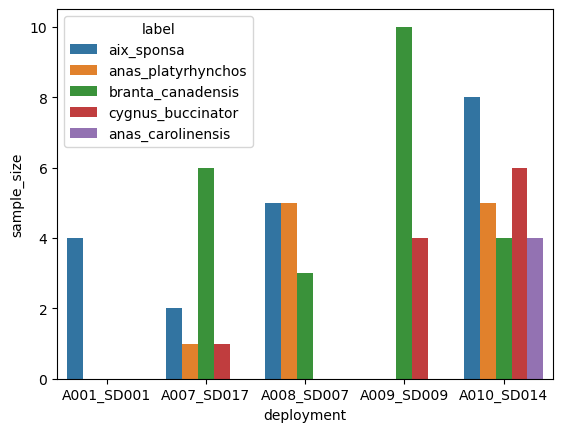

In [29]:
# Let's define annotations class and split classes
all_annotations = BoxedAnnotations.from_raven_files(raven_files=raven_file_paths,audio_files=audio_file_paths, annotation_column="species")

# Let's split audio clips
class_list = ["branta_canadensis", "cygnus_buccinator", "anas_carolinensis", "anas_platyrhynchos", "aix_sponsa"]
labels = all_annotations.clip_labels(
  clip_duration=3,
  clip_overlap=0,
  min_label_overlap=0.25,
  class_subset=class_list
)
train_df, validation_df = train_test_split(labels, test_size=0.2)
# validation_df["empty_class"] = ~validation_df.any(axis=1)
# Let's check how many annotations we have for each species at each site

label_sample_size_dict = {}
species_by_deployment_dfs = []
for label in train_df.columns.values:
    label_df = train_df[train_df[label]]
    deployment_list = []
    for i, row in label_df.reset_index().iterrows():
        path = os.path.normpath(row["file"])
        deployment = path.split(os.sep)[5][:10]
        deployment_list.append(deployment)
    label_deployment_df = pd.DataFrame({"deployment":deployment_list})
    label_deployment_df["label"] = label
    species_by_deployment_dfs.append(label_deployment_df)
    # Group by deployment and species list and   
concatenated_species_by_deployment_sample_size_df = pd.concat(species_by_deployment_dfs)
species_by_deployment_sample_size_df = concatenated_species_by_deployment_sample_size_df.groupby(["deployment", "label"]).size().rename('sample_size').reset_index()
print(species_by_deployment_sample_size_df)
ax = sns.barplot(data=species_by_deployment_sample_size_df, x="deployment", y="sample_size", hue="label")
plt.savefig(
    f"{figures_directory}/train_dataset_deployment_label_sample_sizes.png", bbox_inches="tight", dpi=800
)
plt.close()

# Let's filter training dataframe to reduce the number of empty clips; otherwise model
# may be incentivized to predict empty class 
# training_clips_w_pos_id_df = train_df[train_df.any(axis=1)]
# training_clips_wo_pos_id_df = train_df[~train_df.any(axis=1)]
# training_clips_w_pos_id_df
# print(len(training_clips_w_pos_id_df))
# print(len(training_clips_wo_pos_id_df))
# number_of_files_to_sample = len(training_clips_w_pos_id_df) * 2

# training_clips_wo_pos_id_to_keep_df = training_clips_wo_pos_id_df.sample(number_of_files_to_sample)
# train_df = pd.concat([training_clips_wo_pos_id_to_keep_df, training_clips_w_pos_id_df])
# train_df
# train_df["empty_class"] = ~train_df.any(axis=1)
# train_df.sort_values(["file", "start_time", "end_time"], inplace=True)


label_sample_size_dict = {}
species_by_deployment_dfs = []
for label in validation_df.columns.values:
    label_df = validation_df[validation_df[label]]
    deployment_list = []
    for i, row in label_df.reset_index().iterrows():
        path = os.path.normpath(row["file"])
        deployment = path.split(os.sep)[5][:10]
        deployment_list.append(deployment)
    label_deployment_df = pd.DataFrame({"deployment":deployment_list})
    label_deployment_df["label"] = label
    species_by_deployment_dfs.append(label_deployment_df)
    # Group by deployment and species list and   
concatenated_species_by_deployment_sample_size_df = pd.concat(species_by_deployment_dfs)
species_by_deployment_sample_size_df = concatenated_species_by_deployment_sample_size_df.groupby(["deployment", "label"]).size().rename('sample_size').reset_index()
ax = sns.barplot(data=species_by_deployment_sample_size_df, x="deployment", y="sample_size", hue="label")
plt.savefig(
    f"{figures_directory}/validation_dataset_deployment_label_sample_sizes.png", bbox_inches="tight", dpi=800
)


In [30]:
train_copy_df = train_df.copy()
train_copy_df["empty_class"] = ~train_copy_df.any(axis=1)
train_copy_df.head()

label_sample_size_dict = {}
species_by_deployment_dfs = []
for label in train_copy_df.columns.values:
    label_df = train_copy_df[train_copy_df[label]]
    deployment_list = []
    for i, row in label_df.reset_index().iterrows():
        path = os.path.normpath(row["file"])
        deployment = path.split(os.sep)[5][:10]
        deployment_list.append(deployment)
    label_deployment_df = pd.DataFrame({"deployment":deployment_list})
    label_deployment_df["label"] = label
    species_by_deployment_dfs.append(label_deployment_df)
    # Group by deployment and species list and   
concatenated_species_by_deployment_sample_size_df = pd.concat(species_by_deployment_dfs)
species_by_deployment_sample_size_df = concatenated_species_by_deployment_sample_size_df.groupby(["deployment", "label"]).size().rename('sample_size').reset_index()
ax = sns.barplot(data=species_by_deployment_sample_size_df, x="deployment", y="sample_size", hue="label")
plt.savefig(
    f"{figures_directory}/train_dataset_deployment_label_sample_sizes_w_empty_class_filtered.png", bbox_inches="tight", dpi=800
)
plt.close() 

In [31]:
# This cell contains code to plot histogram of box lengths
spectrogram_df["box_length"] = spectrogram_df["End Time (s)"] - spectrogram_df["Begin Time (s)"]
ax = sns.histplot(data=spectrogram_df, x=spectrogram_df["box_length"])

plt.savefig(
    f"{figures_directory}/raven_waterfowl_box_lengths.png", bbox_inches="tight", dpi=800
)
plt.close()
print("Mean call length:")
print(spectrogram_df["box_length"].mean())

/tmp/ipykernel_172039/2979232536.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spectrogram_df["box_length"] = spectrogram_df["End Time (s)"] - spectrogram_df["Begin Time (s)"]


Mean call length:
0.4679224617342835


In [32]:
# This cell contains code to plot histogram of box widths so that we 
# have a better idea of how to filter based on b

spectrogram_df.head()
spectrogram_df.columns.values
spectrogram_df["box_width"] = spectrogram_df["High Freq (Hz)"] - spectrogram_df["Low Freq (Hz)"]
ax = sns.histplot(data=spectrogram_df, x=spectrogram_df["box_width"])

plt.savefig(
    f"{figures_directory}/raven_waterfowl_box_widths.png", bbox_inches="tight", dpi=800
)

plt.close()

print(spectrogram_df["box_width"].mean())

/tmp/ipykernel_172039/2757516811.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spectrogram_df["box_width"] = spectrogram_df["High Freq (Hz)"] - spectrogram_df["Low Freq (Hz)"]


5038.201665549035


In [33]:
# Preprocessing happens when you initiate the model and call model.preprocessor
# An alternative way to preprocess is to specifically define the preprocessor class
class_list = ['branta_canadensis',
 'cygnus_buccinator',
 'anas_carolinensis',
 'anas_platyrhynchos',
 'aix_sponsa']
# class_list = class_list + ["empty_class"]

pre = SpectrogramPreprocessor(sample_duration=3, overlay_df=train_df)
model = CNN(architecture='resnet18', sample_duration=3, classes=class_list)
model.preprocessor = pre
model.preprocessor.pipeline.bandpass.set(min_f=1000, max_f=9000)

In [34]:
train_df.head()
#dataset[36].data
#dataset[36].labels

,,,branta_canadensis,cygnus_buccinator,anas_carolinensis,anas_platyrhynchos,aix_sponsa
file,start_time,end_time,,,,,
/mnt/class_data/group1_bioacoustics/brett/A001_SD001_20240402_070500.wav,3.0,6.0,False,False,False,False,False
/mnt/class_data/group1_bioacoustics/brett/A001_SD001_20240402_064000.wav,33.0,36.0,False,False,False,False,False
/mnt/class_data/group1_bioacoustics/brett/A001_SD001_20240401_063700.wav,33.0,36.0,False,False,False,False,False
/mnt/class_data/group1_bioacoustics/brett/A002_SD013_20240402_055300.wav,36.0,39.0,False,False,False,False,False
/mnt/class_data/group1_bioacoustics/brett/A001_SD001_20240414_064700.wav,12.0,15.0,False,False,False,False,False


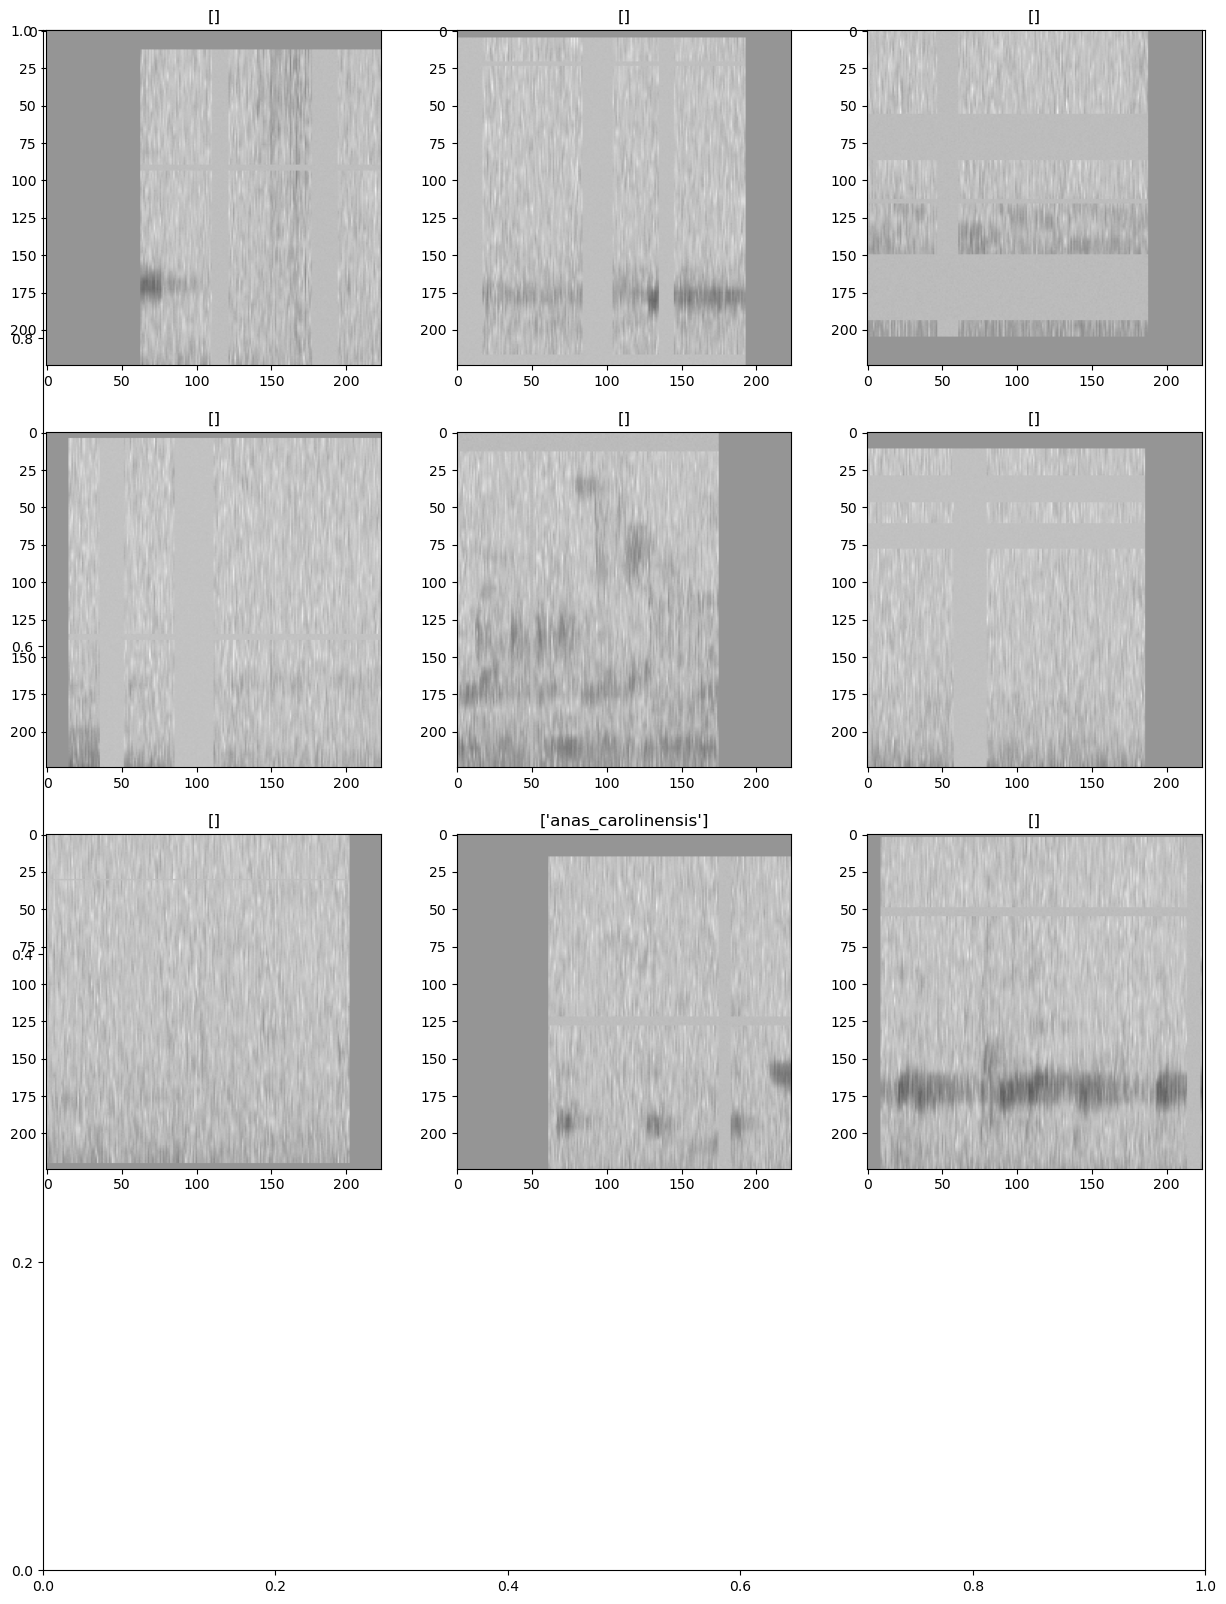

In [35]:
# Set up audio dataset and visualize some samples
dataset = AudioFileDataset(samples=train_df,preprocessor=model.preprocessor)
len(dataset)
# This is just going to visualize random tensors
tensors = [dataset[i].data for i in range(36, 45)]
sample_labels = [list(dataset[i].labels[dataset[i].labels>0].index) for i in range(36, 45)]

_ = show_tensor_grid(tensors,3,labels=sample_labels)

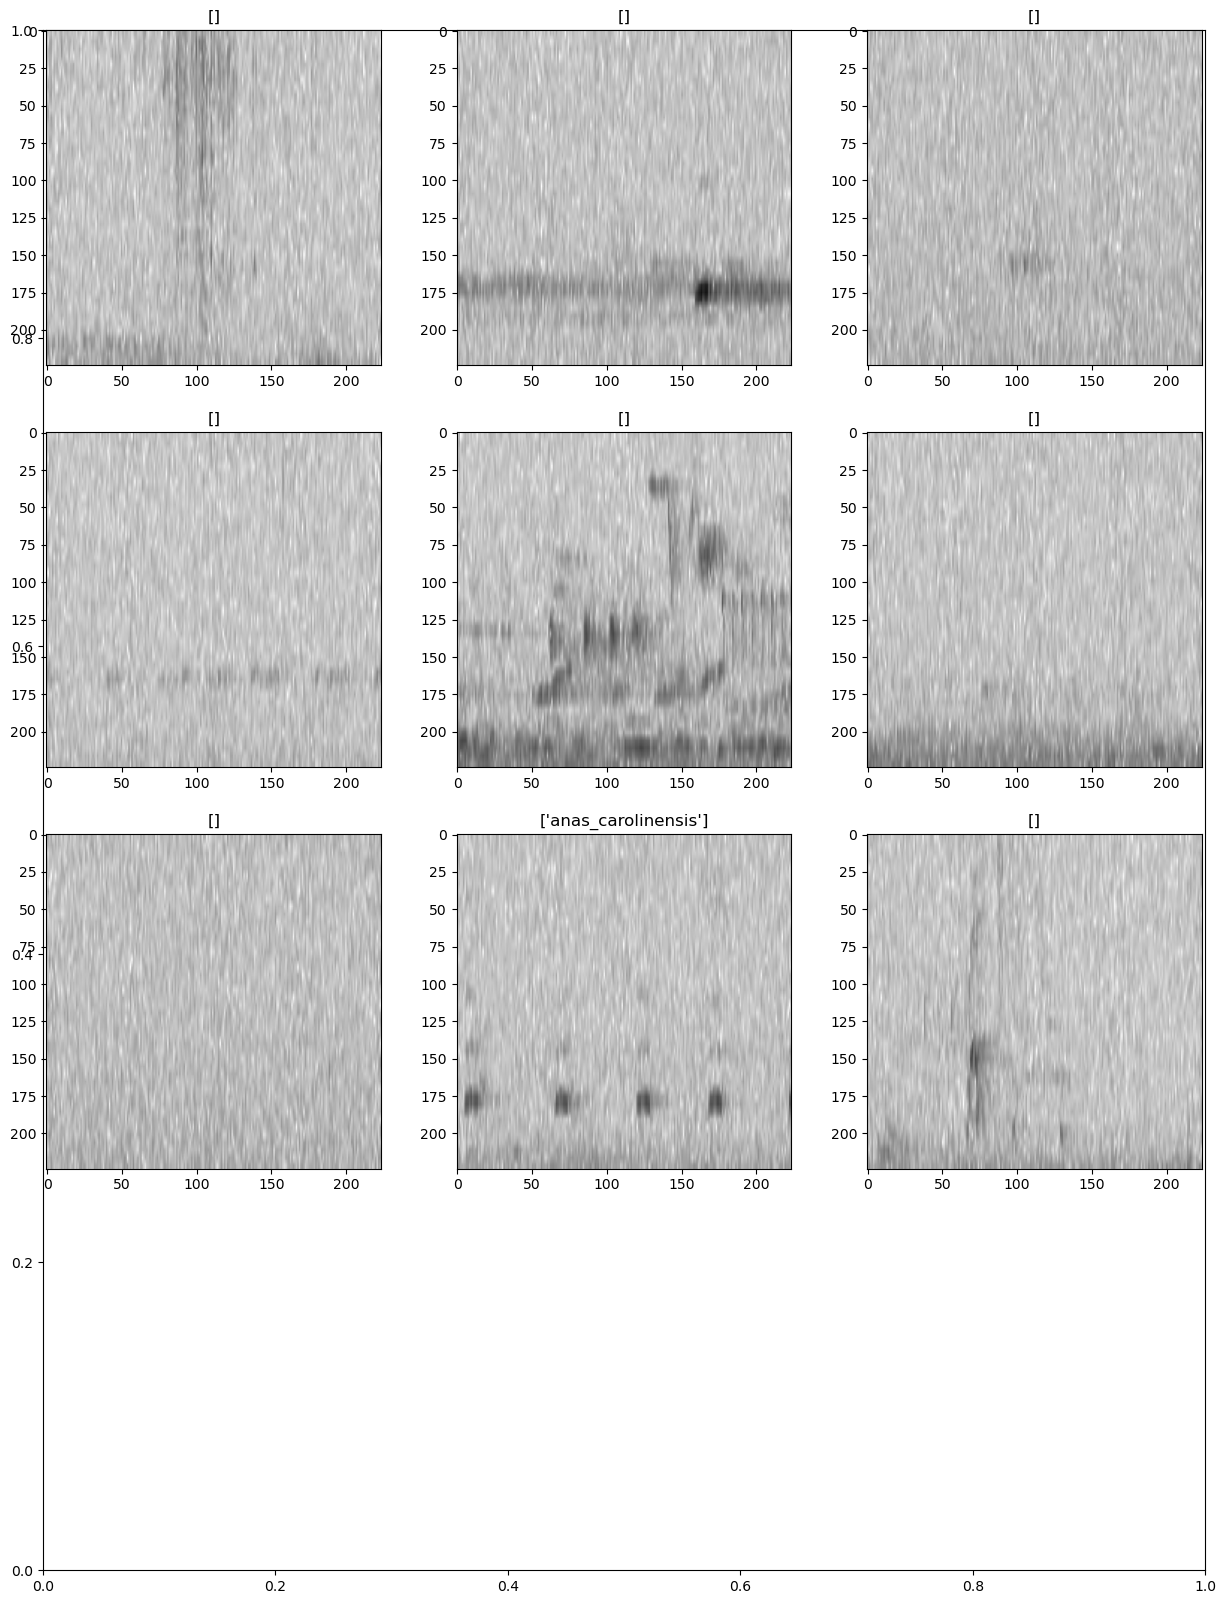

In [36]:
# Set up audio dataset and visualize some samples
dataset.bypass_augmentations = True
# This is just going to visualize random tensors
tensors = [dataset[i].data for i in range(36, 45)]
sample_labels = [list(dataset[i].labels[dataset[i].labels>0].index) for i in range(36, 45)]

_ = show_tensor_grid(tensors,3,labels=sample_labels)

In [37]:
# Let's view positives samples, we need to collect the indices of clips with non null labels
# Do that by collecting the indices of clips where we have a positive label
positive_tensor_indices  = []
for i in range(len(dataset)):
    positive_labels = (dataset[i].labels[dataset[i].labels>0].index)
    if len(positive_labels) > 0:
        positive_tensor_indices.append(i)

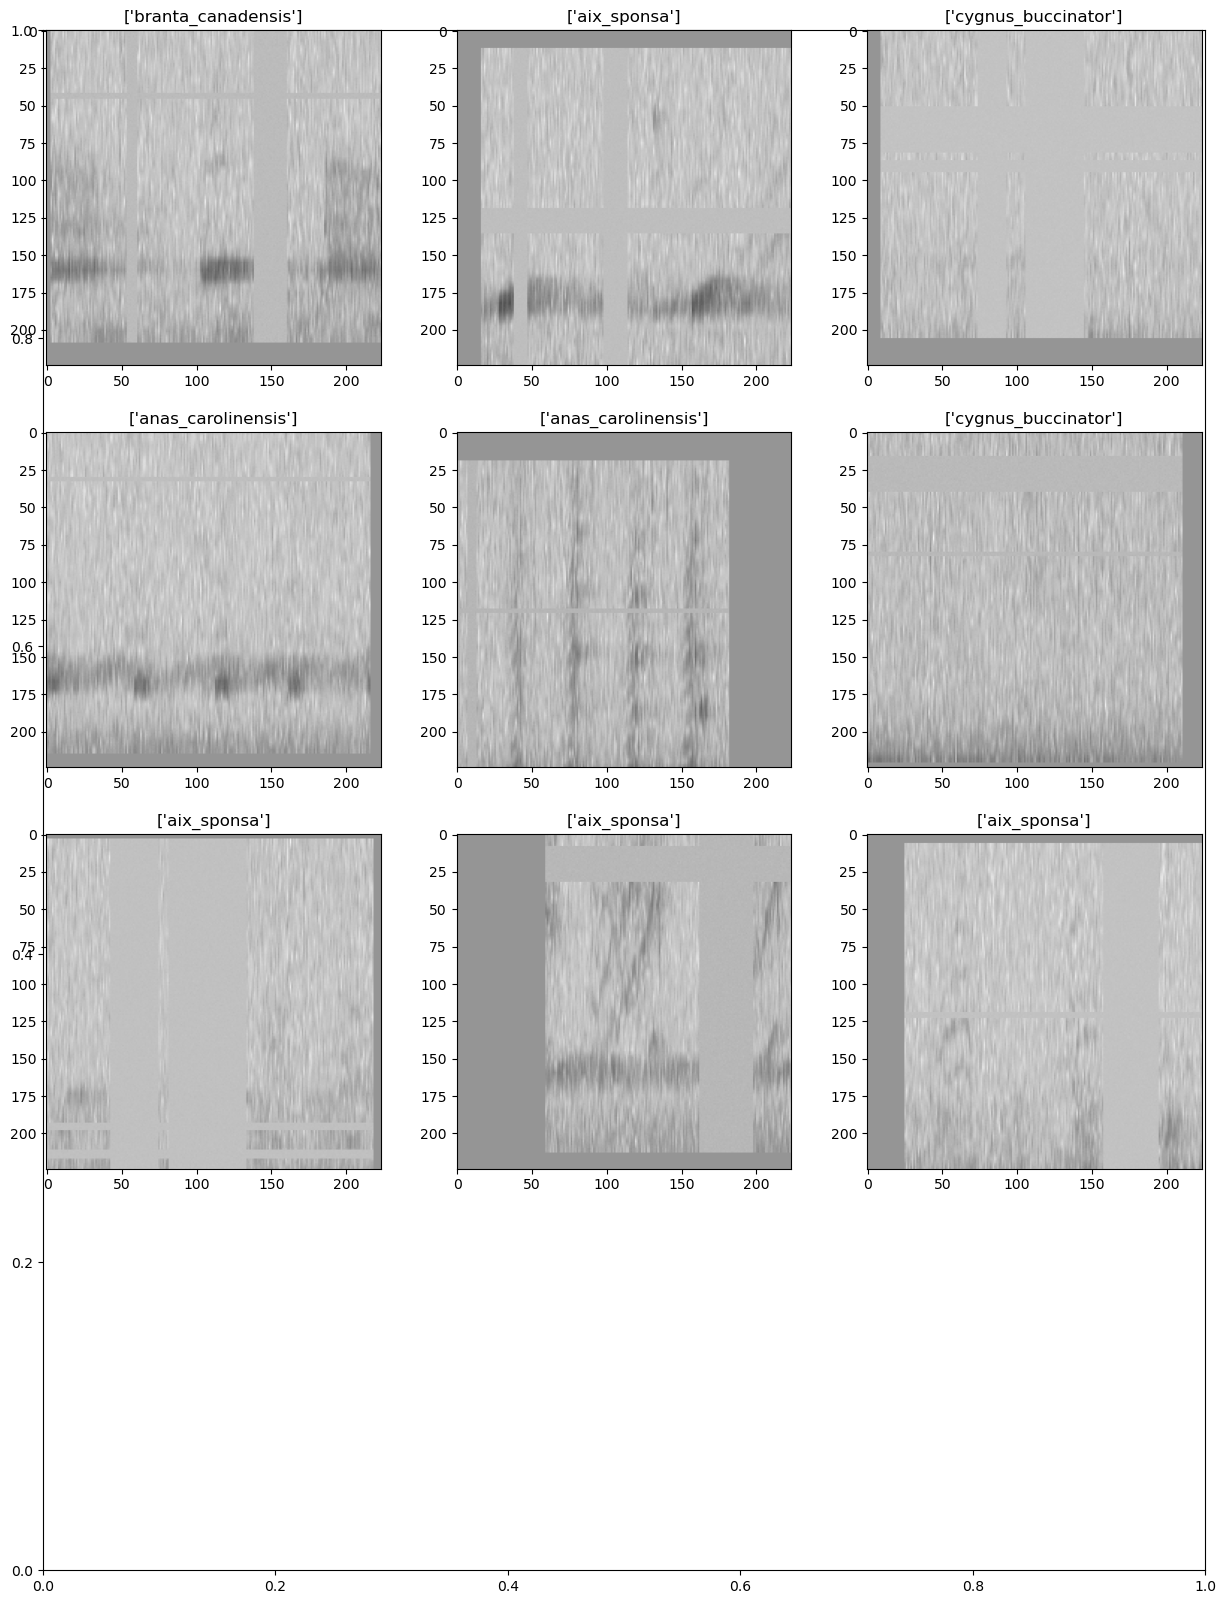

In [38]:
# Let's view some positives samples (n=9) for all classes
dataset = AudioFileDataset(samples=train_df,preprocessor=model.preprocessor)

tensors = []
sample_labels = []
# Change indices in square bracket here to look at different range of positives samples
for i in positive_tensor_indices[:9]:
    tensors.append(dataset[i].data)
    sample_labels.append(list(dataset[i].labels[dataset[i].labels>0].index))

_ = show_tensor_grid(tensors,3,labels=sample_labels)

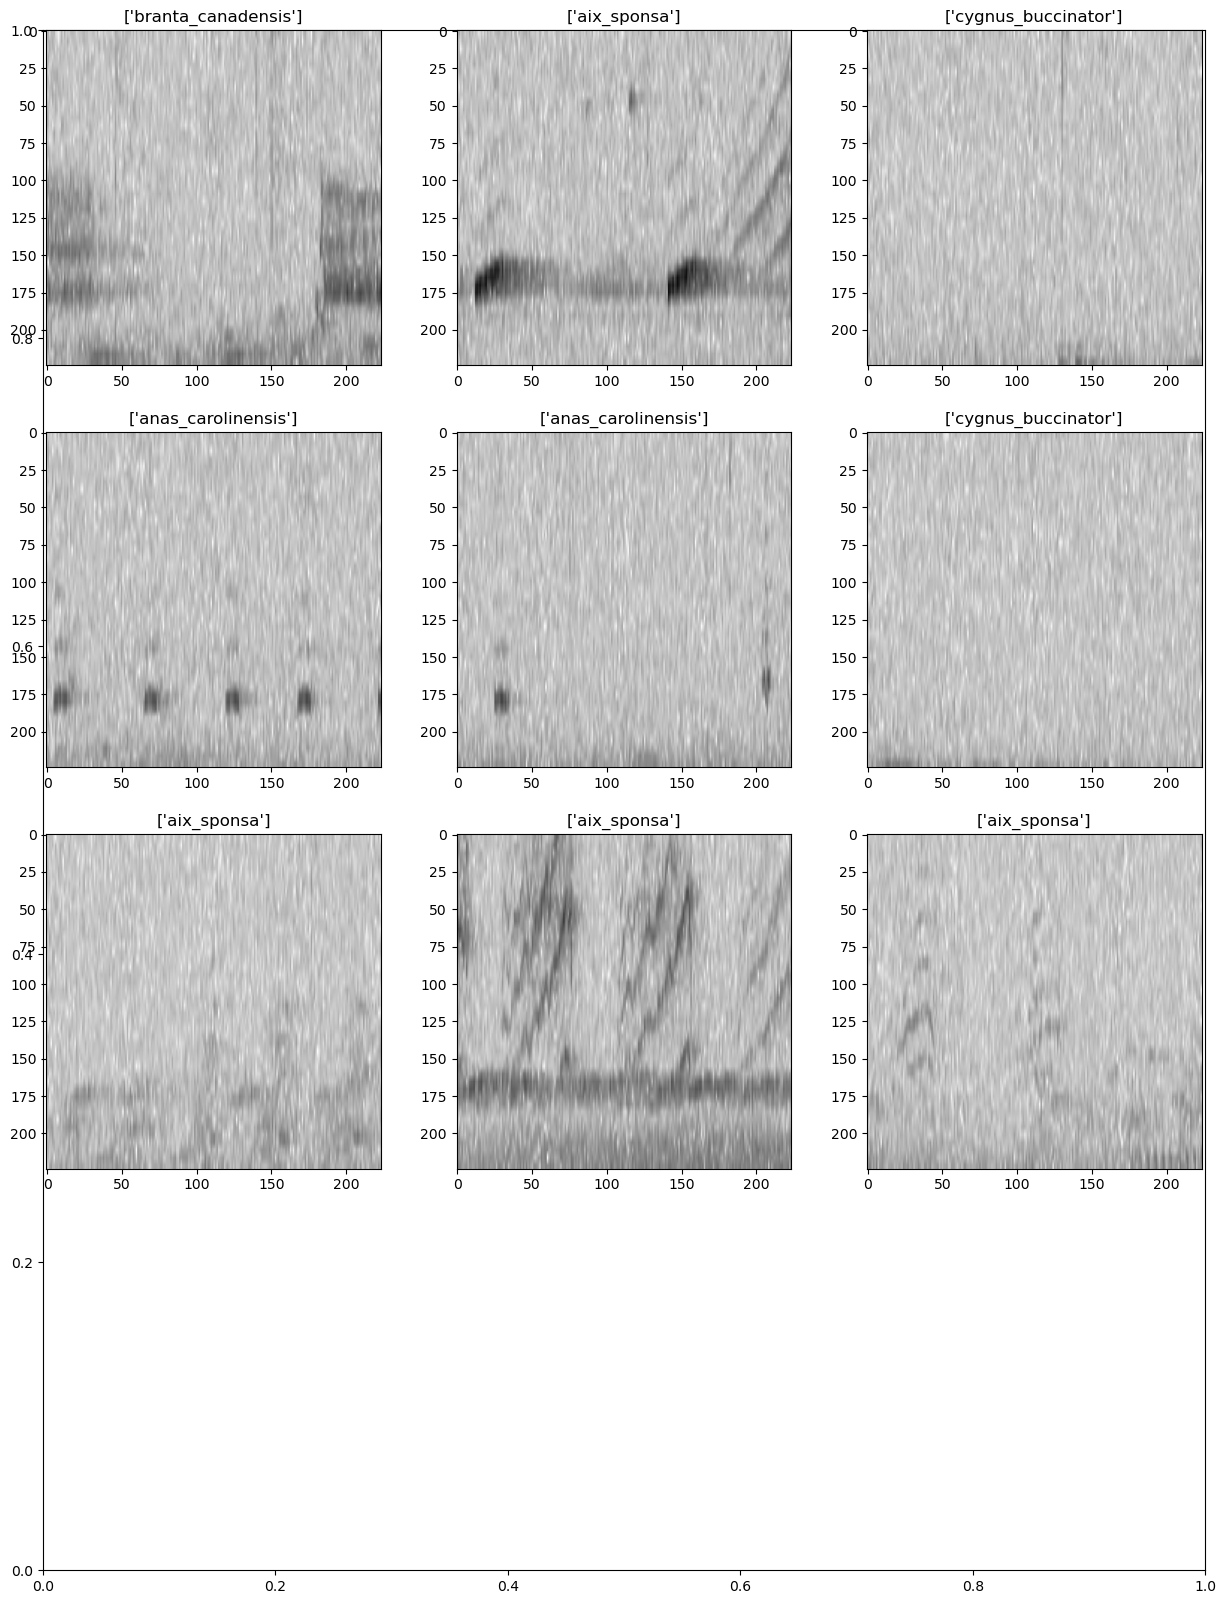

In [39]:
# Let's view some positives samples wo augmentation
dataset.bypass_augmentations = True

tensors = []
sample_labels = []
# Change indices in square bracket here to look at different range of positives samples
for i in positive_tensor_indices[:9]:
    tensors.append(dataset[i].data)
    sample_labels.append(list(dataset[i].labels[dataset[i].labels>0].index))

_ = show_tensor_grid(tensors,3,labels=sample_labels)

In [40]:
#Run once
wandb.login()

wandb: Currently logged in as: brett-michael-ford (brett-michael-ford-st-lawrence-university). Use `wandb login --relogin` to force relogin


True

In [41]:
wandb_session = wandb.init(
    project='nocowild_cv4e_classifier',
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


In [42]:
# Train model
model.train(train_df, validation_df, epochs=5, num_workers=8, batch_size=64, save_path="../nocowild_multi_class_train_20250116_after_filter_empty_class_10_epoch_128_batch/", wandb_session=wandb_session)
wandb.unwatch(model.network)
wandb.finish()


Training Epoch 0


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch: 0 [batch 0/27, 0.00%] 
	Epoch Running Average Loss: 1.058
	Most Recent Batch Loss: 1.058
Epoch: 0 [batch 10/27, 37.04%] 
	Epoch Running Average Loss: 0.322
	Most Recent Batch Loss: 0.177
Epoch: 0 [batch 20/27, 74.07%] 
	Epoch Running Average Loss: 0.270
	Most Recent Batch Loss: 0.233

Validation.


  0%|          | 0/7 [00:00<?, ?it/s]


Training Epoch 1


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch: 1 [batch 0/27, 0.00%] 
	Epoch Running Average Loss: 0.199
	Most Recent Batch Loss: 0.199
Epoch: 1 [batch 10/27, 37.04%] 
	Epoch Running Average Loss: 0.199
	Most Recent Batch Loss: 0.133
Epoch: 1 [batch 20/27, 74.07%] 
	Epoch Running Average Loss: 0.176
	Most Recent Batch Loss: 0.133

Validation.


  0%|          | 0/7 [00:00<?, ?it/s]


Training Epoch 2


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch: 2 [batch 0/27, 0.00%] 
	Epoch Running Average Loss: 0.182
	Most Recent Batch Loss: 0.182
Epoch: 2 [batch 10/27, 37.04%] 
	Epoch Running Average Loss: 0.138
	Most Recent Batch Loss: 0.123
Epoch: 2 [batch 20/27, 74.07%] 
	Epoch Running Average Loss: 0.135
	Most Recent Batch Loss: 0.184

Validation.


  0%|          | 0/7 [00:00<?, ?it/s]


Training Epoch 3


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch: 3 [batch 0/27, 0.00%] 
	Epoch Running Average Loss: 0.064
	Most Recent Batch Loss: 0.064
Epoch: 3 [batch 10/27, 37.04%] 
	Epoch Running Average Loss: 0.107
	Most Recent Batch Loss: 0.120
Epoch: 3 [batch 20/27, 74.07%] 
	Epoch Running Average Loss: 0.113
	Most Recent Batch Loss: 0.158

Validation.


  0%|          | 0/7 [00:00<?, ?it/s]


Training Epoch 4


  0%|          | 0/27 [00:00<?, ?it/s]

Epoch: 4 [batch 0/27, 0.00%] 
	Epoch Running Average Loss: 0.088
	Most Recent Batch Loss: 0.088
Epoch: 4 [batch 10/27, 37.04%] 
	Epoch Running Average Loss: 0.107
	Most Recent Batch Loss: 0.078
Epoch: 4 [batch 20/27, 74.07%] 
	Epoch Running Average Loss: 0.112
	Most Recent Batch Loss: 0.091

Validation.


  0%|          | 0/7 [00:00<?, ?it/s]


Best Model Appears at Epoch 4 with Validation score 0.739.


epoch,▁▃▅▆█
loss,█▄▂▁▁
epoch,4
loss,0.11491
